In [4]:
## IMPORT FUNCTIONS
import os 
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
import random
from sklearn.model_selection import RandomizedSearchCV #GridSearchCV
import xgboost as xgb
import pickle
from random import shuffle

path = '../'
os.chdir(path)
print(os.getcwd()) # printing current working directory

e:\work_projects\2024\KC5FILT


In [5]:
## LOAD DATA
file_name = 'data/PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(file_name)

In [3]:
## ===================================================================================================================================
##                                                   PREP DATA FOR CLASSIFICATION           
## ===================================================================================================================================

In [6]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [8]:
## different types
df_model = df.copy(deep=True)

## Replace letter in 'nameOrig' and 'nameDest' columns
df_model['nameOrig'] = df_model['nameOrig'].str.replace('C','1', regex=True)
df_model['nameDest'] = df_model['nameDest'].str.replace('C','1', regex=True)
df_model['nameOrig'] = pd.to_numeric(df_model['nameOrig'].str.replace('M','2', regex=True))
df_model['nameDest'] = pd.to_numeric(df_model['nameDest'].str.replace('M','2', regex=True))

df_model.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,11231006815,170136.0,160296.36,21979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,11666544295,21249.0,19384.72,22044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,11305486145,181.0,0.00,1553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,1840083671,181.0,0.00,138997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,12048537720,41554.0,29885.86,21230701703,0.0,0.0,0,0


In [9]:
df_model = df_model.drop(['isFlaggedFraud','isFraud'], axis=1)
## manual mapping
#df['type'] = df['type'].map({'PAYMENT':0, 'CASH_OUT':1, 'CASH_IN':2, 'TRANSFER':3, 'DEBIT':4})
## OR encode using 'get_dummies that does one-hot encoding
df_model = pd.get_dummies(df_model)
df_model.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,11231006815,170136.0,160296.36,21979787155,0.0,0.0,False,False,False,True,False
1,1,1864.28,11666544295,21249.0,19384.72,22044282225,0.0,0.0,False,False,False,True,False
2,1,181.00,11305486145,181.0,0.00,1553264065,0.0,0.0,False,False,False,False,True
3,1,181.00,1840083671,181.0,0.00,138997010,21182.0,0.0,False,True,False,False,False
4,1,11668.14,12048537720,41554.0,29885.86,21230701703,0.0,0.0,False,False,False,True,False


In [10]:
df_model.describe()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,6.838778e+09,8.338831e+05,8.551137e+05,8.787058e+09,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,5.087441e+09,2.888243e+06,2.924049e+06,7.477568e+09,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,1.133800e+04,0.000000e+00,0.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,1.537018e+09,0.000000e+00,0.000000e+00,1.759117e+09,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.107374e+10,1.420800e+04,0.000000e+00,1.110992e+10,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.161081e+10,1.073152e+05,1.442584e+05,1.192349e+10,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,1.214748e+10,5.958504e+07,4.958504e+07,2.214748e+10,3.560159e+08,3.561793e+08


In [11]:
## ID MISSING VALUES
df_model.isnull().any()
df_model.isnull().sum().sum()

0

In [12]:
## NORMALISE DATA ALL COLS BUT Type and CATEGORICAL (LAST)

df_model = df_model.drop(['nameOrig','nameDest'], axis=1)
cols = ["step","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

#cols = ["step","amount","nameOrig","oldbalanceOrg","newbalanceOrig","nameDest","oldbalanceDest","newbalanceDest"]

scaler = MinMaxScaler()
scaler.fit(df_model[cols])
df_model[cols] = scaler.transform(df_model[cols])
df_model.head(5)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.0,0.000106,0.002855,0.003233,0.000000,0.0,False,False,False,True,False
1,0.0,0.000020,0.000357,0.000391,0.000000,0.0,False,False,False,True,False
2,0.0,0.000002,0.000003,0.000000,0.000000,0.0,False,False,False,False,True
3,0.0,0.000002,0.000003,0.000000,0.000059,0.0,False,True,False,False,False
4,0.0,0.000126,0.000697,0.000603,0.000000,0.0,False,False,False,True,False


In [11]:
## IDENTIFY FRAUDULENT TRANSACTIONS (FROM CLASSIFICATION)

In [13]:
## laod model
loaded_model = pickle.load(open("model/train_model.sav", 'rb'))
result = loaded_model.predict(df_model)
prob = loaded_model.predict_proba(df_model)

c:\Users\GEdwards\miniconda3\envs\edu_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:36:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [14]:
prob

array([[9.9999958e-01, 4.1870848e-07],
       [9.9999970e-01, 3.1450750e-07],
       [3.7342906e-03, 9.9626571e-01],
       ...,
       [1.8221140e-04, 9.9981779e-01],
       [2.1457672e-05, 9.9997854e-01],
       [6.6059828e-04, 9.9933940e-01]], dtype=float32)

In [15]:
## add score to data
df['Pred'] = result
df['Prob'] = np.round(prob[:,1],2)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Pred,Prob
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0.00
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0.00
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,1.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0.89
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0.00


In [15]:
## ===================================================================================================================================
##                                                   LINK CLIENTS           
## ===================================================================================================================================

In [16]:
### Seed some multi transactions into dataset to better refect reality
'''df_temp = df[df['Pred'] == 1].reset_index(drop=True)
df_aug = []
for ii in range(0,50):
    rnd = random.randint(0, len(df_temp))
    for jj in range(0,random.randint(1,5)):
        amount = df_temp.loc[rnd,'amount']
        df_temp.loc[rnd,'amount'] = amount + random.randint(-int(amount)+1, 5000)
        df_aug.append(df_temp.loc[rnd,:])
df_new = pd.DataFrame(df_aug)
'''
data = df#pd.concat([df, df_new], ignore_index = True)

In [18]:
## Select all "nameOrig" and "nameDest" entries where Pred == 1
df_fraud = data.loc[data['Pred'] == 1]

In [19]:
## SELECT ONLY ACCOUNTS LINKED TO FRAUDULENT TRANSCTIONS
Orig = df_fraud['nameOrig'].to_list()
Dest = df_fraud['nameDest'].to_list()

dfOrig = data[data['nameOrig'].isin(Orig)]
dfDest = data[data['nameDest'].isin(Dest)]

dt = pd.concat([dfOrig, dfDest], ignore_index=True)
dt = dt.drop_duplicates()
dt.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Pred,Prob
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,1,1.00
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,1,0.89
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,1,1.00
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,1,0.92
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,1,1.00


In [20]:
## Seed more CONNECTIONS between other for illustrative purposes (use IDs)
ids = Orig+Dest
ids = list(set(ids))
ids_less = random.sample(ids, 10)

## Seed into Fraudelent
dt_temp1 = dt.copy(deep=True)
df_aug = []
for ii in range(0,int(len(dt_temp1)/2)):
    rnd = random.randint(0, len(dt_temp1))
    a = random.randint(0, len(ids_less)-1)
    dt_temp1.loc[rnd,'nameOrig'] = ids_less[a]
    b = random.randint(0, len(ids_less)-1)
    dt_temp1.loc[rnd,'nameDest'] = ids_less[b]
    df_aug.append(dt_temp1.loc[rnd,:])
D = pd.DataFrame(df_aug).sample(frac=1)

## Seed into Other dataframe
dt_temp2 = data.loc[data['Pred'] == 0]
df_aug = []
for ii in range(0,100):
    rnd = random.randint(0, len(dt_temp2))
    a = random.randint(0, len(ids_less)-1)
    if randint(0, 1) == 0:
        dt_temp2.loc[rnd,'nameOrig'] = ids_less[a]
    else:    
        dt_temp2.loc[rnd,'nameDest'] = ids_less[a]
    df_aug.append(dt_temp2.loc[rnd,:])
DD = pd.DataFrame(df_aug).sample(frac=1)


In [21]:
data_new = pd.concat([D, DD, dt], ignore_index=True)
data_new = data_new.dropna()
data_new = data_new.drop_duplicates()
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Pred,Prob
0,514.0,CASH_OUT,28659.80,C1879397053,27756.7,0.00,C356110177,341223.26,369883.06,0.0,0.0,1.0,0.62
1,134.0,CASH_OUT,147698.47,C970108067,313104.0,165405.53,C2122237253,2441272.92,2588971.39,0.0,0.0,0.0,0.00
2,187.0,CASH_OUT,236046.89,C970108067,41785.0,0.00,C1401275229,146607.42,382654.31,0.0,0.0,0.0,0.00
3,354.0,CASH_OUT,208695.42,C1956024073,1.0,0.00,C1401275229,4006532.76,4215228.18,0.0,0.0,0.0,0.00
4,180.0,CASH_OUT,188379.31,C1653796300,27259.0,0.00,C970108067,0.00,188379.31,0.0,0.0,0.0,0.00


In [36]:
# Save seeded dataset
data_new.to_csv('output/transaction_model_output.csv')

In [22]:
## Grab only IDs that is flagged as fraudulent
#data_fraud = data_new.loc[data_new['Pred'] == 1]
## OR Grab only IDs that is flagged as > 80% chance of being fraudulent
data_fraud = data_new.loc[data_new['Prob'] > 0.8]

ID_FRAUD = data_fraud['nameOrig'].to_list() + data_fraud['nameDest'].to_list()
ID_FRAUD = list(dict.fromkeys(ID_FRAUD))

In [23]:
g = data_fraud.groupby(['nameOrig','nameDest'])['amount'].sum()
j = data_fraud.groupby(['nameOrig','nameDest']).size().to_frame('count')
filter_data = pd.merge(g, j, left_index=True, right_index=True).reset_index()
filter_data = filter_data.sort_values('count', ascending=False)
filter_data.head()

,nameOrig,nameDest,amount,count
4255,C220809630,C1527835008,8.780176e+07,53
2393,C1653796300,C1956024073,1.046474e+08,52
4262,C220809630,C356110177,8.181374e+07,48
4261,C220809630,C220809630,4.862571e+07,46
1437,C1401275229,C970108067,8.283998e+07,45


In [24]:
## FILTER
audit_theshold = 50000
filter2 = filter_data.loc[(filter_data['amount'] >= (audit_theshold - (audit_theshold*0.1))) | (filter_data['count'] >= 35)]  ### 10% below audit theshold

In [25]:
use = filter2.loc[(filter2['count'] >= 35)]
use.head()

,nameOrig,nameDest,amount,count
4255,C220809630,C1527835008,8.780176e+07,53
2393,C1653796300,C1956024073,1.046474e+08,52
4262,C220809630,C356110177,8.181374e+07,48
4261,C220809630,C220809630,4.862571e+07,46
1437,C1401275229,C970108067,8.283998e+07,45


In [26]:
use = use.reset_index()
ID = list(use["nameOrig"])+list(use["nameDest"])

In [27]:
A = pd.DataFrame(ID)
UnqIDs = list(A.iloc[:,0].unique())
len(UnqIDs)

10

In [28]:
## Network analysis
import networkx as nx
import matplotlib.pyplot as plt

lst_temp = use[['nameOrig','nameDest']].values.tolist()

##Remove dups
lst = []
for ll in lst_temp:
    tmp = set(ll)
    if len(tmp)>1:
        lst.append(list(tmp))

tpl_lst = [tuple(l) for l in lst]
tpl_lst[0:5]

[('C220809630', 'C1527835008'),
 ('C1653796300', 'C1956024073'),
 ('C220809630', 'C356110177'),
 ('C970108067', 'C1401275229'),
 ('C1982709686', 'C1879397053')]

In [29]:
ID_FRAUD_ESTABL = [lst[5][0],lst[6][1]]#["C514777944","C56779001"]

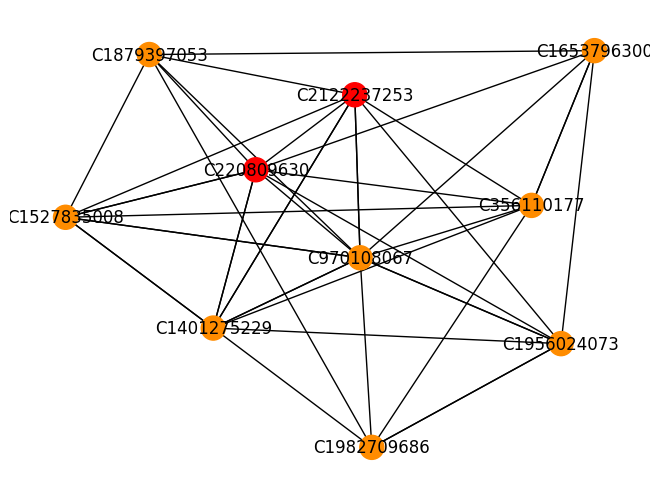

In [30]:
## Network for filters - show only connections (account pairs) that is applicable to the filter
## other option: show ACCOUNTS that is applicable to the filter with all their connections
G = nx.MultiGraph()

## set up
G.add_nodes_from(ID)
G.add_edges_from(tpl_lst)

## Highlight IDs tagged as Fraud or Terrorist
color_map = []
for node in G:
    if node in ID_FRAUD_ESTABL:
        color_map.append('red')
    elif node in ID_FRAUD:
        color_map.append('darkorange')
    else: 
        color_map.append('blue')
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()


In [31]:
### Visualise netword for specific ID

account_id = lst[1][0] #ID_FRAUD_ESTABL[0]

a = data_new.loc[data_new['nameOrig'] == account_id]
b = data_new.loc[data_new['nameDest'] == account_id]
new = pd.concat([a, b], ignore_index=True)
new = new[['nameOrig','nameDest']]
new = new.drop_duplicates()
new['tuples'] = list(zip(new.nameOrig, new.nameDest))
tpl_new = new['tuples'].to_list()

In [32]:
from itertools import chain
#tpl_new = tpl_new[5:10]
ID_new = list(chain.from_iterable(tpl_new))
ID_new = list(dict.fromkeys(ID_new))

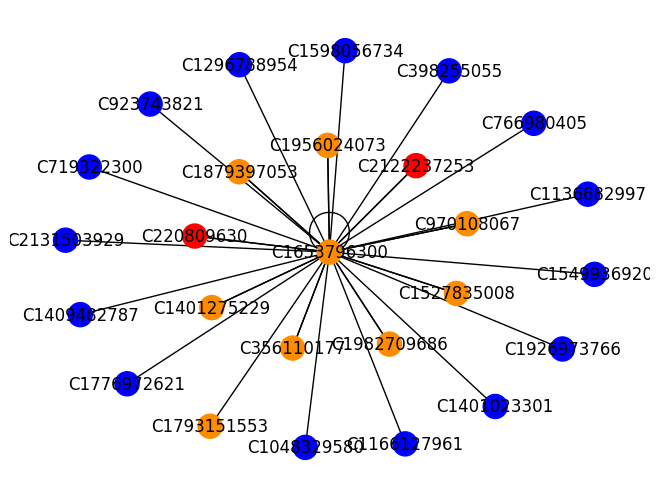

In [33]:
## Visualise

Gnew = nx.MultiGraph()

## set up
Gnew.add_nodes_from(ID_new)
Gnew.add_edges_from(tpl_new)

## Highlight IDs tagged as Fraud or Terrorist
color_map = []
for node in Gnew:
    if node in ID_FRAUD_ESTABL:
        color_map.append('red')
    elif node in ID_FRAUD:
        color_map.append('darkorange')
    else: 
        color_map.append('blue')
        
nx.draw(Gnew, node_color=color_map, with_labels=True)
plt.show()

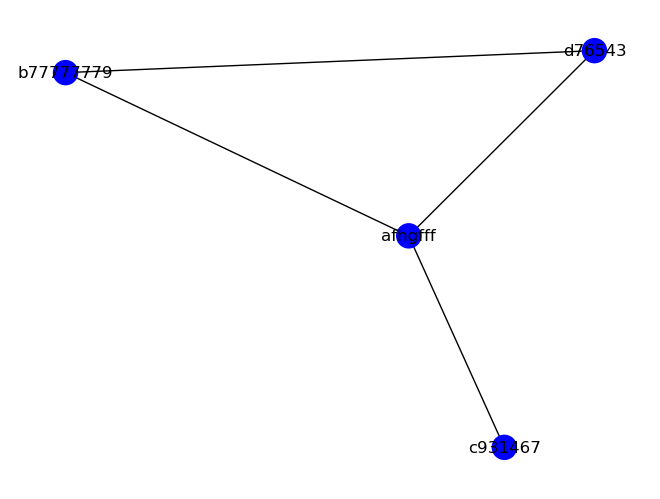

In [127]:
### ===============================================================================================================
### JUST TESTING PLOTTING
### ===============================================================================================================

import networkx as nx

t = [('afhgfff','b77777779'),('afhgfff','c931467'),('afhgfff','d76543'),('b77777779','d76543')]
n = list(chain.from_iterable(t))
n = list(dict.fromkeys(n))


Gtest = nx.MultiGraph()

## set up
Gtest.add_nodes_from(n)
Gtest.add_edges_from(t)

color_map = []
for node in Gtest:
    if node == 'b':
        color_map.append('red')
    else: 
        color_map.append('blue')

nx.draw(Gtest, node_color=color_map, with_labels=True)
plt.show()
